In [1]:
import glob
import json
import pickle
import os
import calendar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from requests import get
from bs4 import BeautifulSoup

In [2]:
full_df = pd.concat([pd.read_csv(f, compression='gzip') for f in glob.glob("../data/full-data/*.gzip")], ignore_index=True)
full_df

,GLOBALEVENTID,MentionSourceName,DocumentIdentifier,DATE,V2Tone
0,714712065,npr.org,https://www.npr.org/podcasts/510318/up-first,20171213163000,"-1.51745068285281,1.97268588770865,3.490136570..."
1,714694876,npr.org,https://www.npr.org/podcasts/510318/up-first,20171213163000,"-1.51745068285281,1.97268588770865,3.490136570..."
2,714914448,npr.org,https://www.npr.org/podcasts/510318/up-first,20171213163000,"-1.51745068285281,1.97268588770865,3.490136570..."
3,714914794,npr.org,https://www.npr.org/podcasts/510318/up-first,20171213163000,"-1.51745068285281,1.97268588770865,3.490136570..."
4,714913892,npr.org,https://www.npr.org/podcasts/510318/up-first,20171213163000,"-1.51745068285281,1.97268588770865,3.490136570..."
5,714694328,npr.org,https://www.npr.org/podcasts/510318/up-first,20171213163000,"-1.51745068285281,1.97268588770865,3.490136570..."
6,721613923,npr.org,https://www.npr.org/series/473636949/schoolmoney,20180111203000,"0,3.18471337579618,3.18471337579618,6.36942675..."
7,771525591,npr.org,https://www.npr.org/podcasts/381444767/u-w-m-t...,20180712174500,"-1.00090991810737,1.45586897179254,2.456778889..."
8,771526954,npr.org,https://www.npr.org/podcasts/381444767/u-w-m-t...,20180712174500,"-1.00090991810737,1.45586897179254,2.456778889..."
9,733479049,npr.org,https://www.npr.org/series/347174484/jazz-nigh...,20180223211500,"1.26742712294043,3.80228136882129,2.5348542458..."


In [3]:
sources = full_df["MentionSourceName"].unique()

In [4]:
nb_articles = full_df.groupby("MentionSourceName")['DocumentIdentifier'].nunique()

In [6]:
nb_articles.sort_values(ascending=False)

MentionSourceName
seattletimes.com       79974
foxnews.com            52521
nbcnews.com            51525
miamiherald.com        48835
stltoday.com           42411
chicagotribune.com     38323
seattlepi.com          37154
nydailynews.com        36094
nytimes.com            33483
latimes.com            26274
newsmax.com            26146
wtop.com               25626
nypost.com             21680
newsweek.com           21590
usatoday.com           20497
breitbart.com          19884
philly.com             18865
bostonherald.com       17704
cbsnews.com            16032
abc13.com              15733
huffingtonpost.com     15383
abc7news.com           12630
newsday.com            12234
npr.org                11995
politico.com           11487
fox2now.com             8832
ktla.com                7975
mercurynews.com         7721
boston.com              7464
kron4.com               7085
denverpost.com          6133
wgntv.com               5951
kdvr.com                5589
kxan.com                5

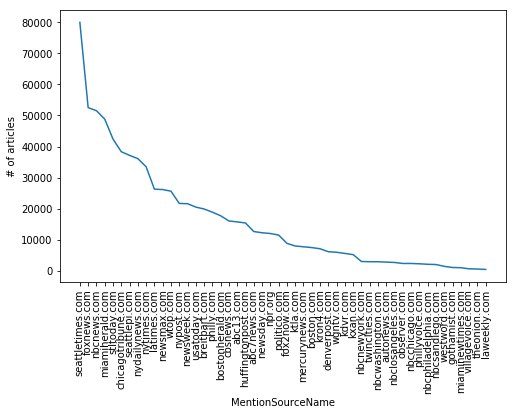

In [8]:
plt.figure(figsize=(8,5))
nb_articles.sort_values(ascending=False).plot()
plt.xticks(range(len(nb_articles)), nb_articles.sort_values(ascending=False).index, rotation=90)
plt.ylabel("# of articles")
plt.show()

In [9]:
full_df["month"] = pd.to_datetime(full_df.DATE, format='%Y%m%d%H%M%S').dt.strftime("%b-%y")

In [10]:
with open("../data/sources/map_sources_url_to_name.pkl", "rb") as f:
    name_map = pickle.load(f)

In [11]:
def get_icon(website, errors):
    possible = ["shortcut icon", "icon", "Shortcut Icon"]
    my_header = {'user-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:63.0) Gecko/20100101 Firefox/63.0",}
    url = "http://"+website
    try:
        r = get(url, headers=my_header)
        soup = BeautifulSoup(r.text, 'html.parser')
        icon_link = None
        i = 0
        while icon_link is None:
            icon_link = soup.find("link", rel=possible[i])
            i+=1
        try:
            icon = get(icon_link['href'], headers=my_header)
            url = icon_link['href']
        except:
            icon = get(url + icon_link['href'], headers=my_header)
            url += icon_link['href']
        return url
    except:
        errors.append(website)

In [12]:
icon_map = {}
errors_icon = []

for s in tqdm_notebook(sources):
    icon_map[s] = get_icon(s, errors_icon)
    
icon_map["npr.org"] = "https://media.npr.org/templates/favicon/favicon-32x32.png"
icon_map["http://chicagotribune.com"] = "https://s.m.huffpost.com/assets/favicon-2020e123c064086aad150fe909c53771f862d7c76cd62f6146e81d533845fd7d.ico"

In [13]:
MONTH_LIST = list(set(full_df["month"].unique())-{'Dec-18'}|{'full_year'})
THEME_LIST = [ "all", "social", "conflict", "env", "health", "eco" ]

In [14]:
ind = {}
ind['all'] = full_df.index.values
for theme in THEME_LIST[1:]:
    with open("../data/indices/"+theme+".pkl", "rb") as f:
        ind[theme] = pickle.load(f)

In [15]:
for theme in tqdm_notebook(THEME_LIST):

    theme_df = full_df.loc[ind[theme]]
    
    for month in tqdm_notebook(MONTH_LIST):
        directory = "../data/"+theme+"/"+month
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        if month == 'full_year':
            df = theme_df.copy()
        else:
            df = theme_df[theme_df.month==month].copy()
        
        sources = df["MentionSourceName"].unique()
        
        events_covered = df.groupby("MentionSourceName")["GLOBALEVENTID"].unique()

        df["avg_tone"] = df.V2Tone.map(lambda l : str(l).split(",")[0]).astype(float)

        avg_tone_by_source_x_event = df.groupby(["MentionSourceName","GLOBALEVENTID"]).mean()["avg_tone"]

        nodes = []
        edges = []
        new_sources = set(sources)

        for source1 in sources:
            nodes.append({  'id' : source1, 
                            'size' : int(nb_articles[source1]), 
                            'name' : name_map[source1],
                            'favicon' : icon_map[source1],
                            'avg_tone' : avg_tone_by_source_x_event[source1].mean(),
                         })

            events1 = set(events_covered[source1])
            new_sources = new_sources - {source1}

            for source2 in new_sources:
                if source1==source2:
                    continue

                events2 = set(events_covered[source2])
                # union
                #coverage_ratio = len(events1 & events2) / len(events1 | events2)

                # sqrt
                #coverage_ratio = len(events1 & events2) / np.sqrt(len(events1) * len(events2))

                # min
                coverage_ratio = len(events1 & events2) / min(len(events1), len(events2))

                tone_diff = np.abs(avg_tone_by_source_x_event[source1]-avg_tone_by_source_x_event[source2]).dropna().mean()

                edges.append({'source': source1, 'target': source2, 'weight': coverage_ratio, 'tone_diff': tone_diff})  

        for i in np.arange(0,0.201,0.005):
            threshold = i
            filtered_edges = [ e for e in edges if e['weight'] > threshold ]
            network = {'nodes': nodes, 'edges': filtered_edges}
            
            filename = "/threshold_"+str(int(threshold*1000))+"_permille.json"
                
            with open(directory+filename, "w") as f:
                json.dump(network, f, indent=2)